# Data block foundations, in Swifty/functional style

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_07_batchnorm")' FastaiNotebook_07_batchnorm
%install '.package(path: "$cwd/SwiftCV")' SwiftCV

Installing packages:
	.package(path: "/home/jhoward/git/fastai_docs/dev_swift/FastaiNotebook_07_batchnorm")
		FastaiNotebook_07_batchnorm
	.package(path: "/home/jhoward/git/fastai_docs/dev_swift/SwiftCV")
		SwiftCV
With SwiftPM flags: []
Working in: /tmp/tmp71xwxz9_/swift-install
/home/jhoward/swift/usr/bin/swift-build: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jhoward/swift/usr/lib/swift/linux/libFoundation.so)
/home/jhoward/swift/usr/bin/swift-build: /home/jhoward/anaconda3/lib/libcurl.so.4: no version information available (required by /home/jhoward/swift/usr/lib/swift/linux/libFoundation.so)
Compile COpenCV core.cpp
/home/jhoward/swift/usr/bin/swiftc: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (required by /home/jhoward/swift/usr/bin/swiftc)
Compile Swift Module 'SwiftCV' (4 sources)
/home/jhoward/swift/usr/bin/swiftc: /home/jhoward/anaconda3/lib/libuuid.so.1: no version information available (requi

In [ ]:
import Path
import TensorFlow
import Python

In [ ]:
import FastaiNotebook_07_batchnorm

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## DataBlock-like manipulation in a lightweight functional, Swifty style

The DataBlock API in Python is designed to help with the routine data manipulations involved in modelling: downloading data, loading it given an understanding of its layout on the filesystem, processing it, and feeding it into an ML framework like fastai. This is a data pipeline. How do we do this in Swift?

One approach is to build a set of types (structs, protocols, etc.) which represent various stages of this pipeline. By making the types generic, we could build a library that handled data for many kinds of models. However, it is sometimes a good rule of thumb, before writing generic types, to start by writing concrete types and then to notice what to abstract into a generic later. And another good rule of thumb, before writing concrete types, is to write no types at all, and to see how far you can get with a more primitive tool for composition: functions.

This notebook shows how to perform DataBlock-like operations using a _lightweight functional style_. This means, first, to rely as much as possible on _pure_ functions -- that is, functions which do nothing but return outputs based on their inputs, and which don't mutate values anywhere. Second, in particular, it means to use Swift's support for _higher-order functions_ (functions which take functions, like `map`, `filter`, `reduce`, and `compose`). Finally, this example relies on _tuples_. Like structs, tuples can have named, typed properties. Unlike structs, you don't need to name them. They can be a fast, ad-hoc way to explore the data types that you actually need, without being distracted by considering what's a method, an initializer, etc.,

Swift has excellent, understated support for a such a style. 

## Getting Started

First things first, we need to download Imagenette and untar it. What follows is very close to what we did for MNIST.

In [ ]:
public let dataPath = Path.home/".fastai"/"data"

In [ ]:
public func downloadImagenette(path: Path = dataPath, sz:String="-320") -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette\(sz).tgz"
    let fname = "imagenette\(sz)"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = "/bin/tar".shell("-xzf", (path/"\(fname).tgz").string, "-C", path.string)
    }
    return file
}

In [ ]:
//export
public func collectFiles(under path: Path, recurse: Bool = false, filtering extensions: [String]? = nil) -> [Path] {
    var res: [Path] = []
    for p in try! path.ls(){
        if p.kind == .directory && recurse { 
            res += collectFiles(under: p.path, recurse: recurse, filtering: extensions)
        } else if extensions == nil || extensions!.contains(p.path.extension.lowercased()) {
            res.append(p.path)
        }
    }
    return res
}

In [ ]:
public protocol DatasetConfig {
    associatedtype Item
    associatedtype Label
    
    static func download() -> Path
    static func getItems(_ path: Path) -> [Item]
    static func isTraining(_ item: Item) -> Bool
    static func labelOf(_ item: Item) -> Label
}

In [ ]:
enum ImageNette: DatasetConfig {
    
    public static func download() -> Path { return downloadImagenette() }
    
    public static func getItems(_ path: Path) -> [Path] {
        return collectFiles(under: path, recurse: true, filtering: ["jpeg", "jpg"])
    }
    
    public static func isTraining(_ p:Path) -> Bool {
        return p.parent.parent.basename() == "train"
    }
    
    public static func labelOf(_ p:Path) -> String { return p.parent.basename() }
}


In [ ]:
func describeSample<C>(_ item: C.Item, config: C.Type) where C: DatasetConfig {
    let isTraining = C.isTraining(item)
    let label = C.labelOf(item)
    print("""
          item: \(item)
          training?:  \(isTraining)
          label: \(label)
          """)
}

In [ ]:
let path = ImageNette.download()
let allFnames = ImageNette.getItems(path)

In [ ]:
describeSample(allFnames[0], config: ImageNette.self)

item: /home/jhoward/.fastai/data/imagenette-320/val/n03417042/ILSVRC2012_val_00047189.JPEG
training?:  false
label: n03417042


In [ ]:
func partitionIntoTrainVal<T>(_ items:[T],isTrain:((T)->Bool)) -> (train:[T],valid:[T]){
    return (train: items.filter(isTrain), valid: items.filter { !isTrain($0) })
}

In [ ]:
public protocol Processor {
    associatedtype Input
    associatedtype Output
    
    mutating func initState(_ items: [Input])
    func process  (_ item: Input)  -> Output
    func deprocess(_ item: Output) -> Input
}

In [ ]:
public struct CategoryProcessor: Processor {
    private(set) public var intToLabel: [String] = []
    private(set) public var labelToInt: [String:Int] = [:]
    
    public mutating func initState(_ items: [String]) {
        intToLabel = Array(Set(items)).sorted()
        labelToInt = Dictionary(uniqueKeysWithValues:
            intToLabel.enumerated().map({ ($0.element, $0.offset) }))
    }
    
    public func process(_ item: String) -> Int { return labelToInt[item]! }
    public func deprocess(_ item: Int) -> String { return intToLabel[item] }
}

In [ ]:
struct SplitLabeledData<Item,Label> {
    var train: [(x: Item, y: Label)]
    var valid: [(x: Item, y: Label)]
    
    init(train: [(x: Item, y: Label)], valid: [(x: Item, y: Label)]) {
        (self.train,self.valid) = (train,valid)
    }
}

And we can define a convenience init to build this directly from the filenames.

In [ ]:
// export
public func >| <A, B, C>(_ lhs: @escaping (A) -> B,
                   _ rhs: @escaping (B) -> C) -> (A) -> C {
    return { rhs(lhs($0)) }
}

In [ ]:
public func makeSLD<C:DatasetConfig, P:Processor>(config: C.Type, procL: inout P)
-> SplitLabeledData<C.Item, P.Output> where P.Input == C.Label {
    let path = C.download()
    let items = C.getItems(path)
    let samples = partitionIntoTrainVal(items, isTrain:C.isTraining)
    let trainLabels = samples.train.map(C.labelOf)
    procL.initState(trainLabels)
    let itemToProcessedLabel = C.labelOf >| procL.process
    return SplitLabeledData(train: samples.train.map { ($0, itemToProcessedLabel($0)) },
                            valid: samples.valid.map { ($0, itemToProcessedLabel($0)) })
}

In [ ]:
var procL = CategoryProcessor()
let sld = makeSLD(config: ImageNette.self, procL: &procL)

### opening images

We can use the same compose approach to convert our images from `Path` filenames to resized images.

In [ ]:
import Foundation
import SwiftCV

First let's open those images with openCV:

In [ ]:
func openImage(_ fn: Path) -> Mat {
    return imdecode(try! Data(contentsOf: fn.url))
}

And add a convenience function to have a look.

In [ ]:
func showCVImage(_ img: Mat) {
    let tensImg = Tensor<UInt8>(cvMat: img)!
    let numpyImg = tensImg.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

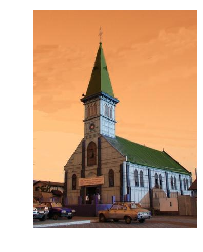

In [ ]:
showCVImage(openImage(sld.train.randomElement()!.x))

The channels are in BGR instead of RGB so we first switch them with openCV

In [ ]:
func BGRToRGB(_ img: Mat) -> Mat {
    return cvtColor(img, nil, ColorConversionCode.COLOR_BGR2RGB)
}

Then we can resize them

In [ ]:
func resize(_ img: Mat, size: Int) -> Mat {
    return resize(img, nil, Size(size, size), 0, 0, InterpolationFlag.INTER_LINEAR)
}

With our compose operator, the succession of transforms can be written in this pretty way:

In [ ]:
let transforms = openImage >| BGRToRGB >| { resize($0, size: 224) }

And we can have a look at one of our elements:

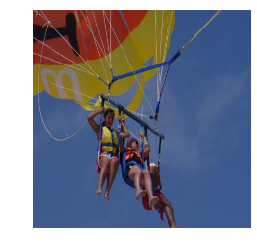

In [ ]:
showCVImage(transforms(sld.train.randomElement()!.x))

## Conversion to Tensor and batching

Now we will need tensors to train our model, so we need to convert our images and ints to tensors.

In [ ]:
func cvImgToTensor(_ img: Mat) -> TF {
    return TF(Tensor<UInt8>(cvMat: img)!) / 255.0
}

We compose our transforms with that last function to get tensors.

In [ ]:
let pathToTF = transforms >| cvImgToTensor

In [ ]:
func intTOTI(_ i: Int) -> TI { return TI(Int32(i)) } 

Now we define a `Batcher` that will be responsible for creating minibatches as an iterator. It has the properties you know from PyTorch (batch size, num workers, shuffle) and will use multiprocessing to gather the images in parallel.

To be able to write `for batch in Batcher(...)`, `Batcher` needs to conform to `Sequence`, which means it needs to have a `makeIterator` function. That function has to return another struct that conforms to `IteratorProtocol`. The only thing required there is a `next` property that returns the next batch (or `nil` if we are finished).

The code is pretty striaghtforward: we shuffle the dataset at each beginning of iteration if we want, then we apply the transforms in parallel with the use of `concurrentMap`, that works just like map but with `numWorkers` processes.

In [ ]:
struct Batcher<Item,Label,ScalarI:TensorFlowScalar,ScalarL:TensorFlowScalar>: Sequence {
    let dataset: [(Item, Label)]
    let xToTensor: (Item) -> Tensor<ScalarI>
    let yToTensor: (Label) -> Tensor<ScalarL>
    var bs: Int = 64
    var numWorkers: Int = 4
    var shuffle: Bool = false
    
    init(_ ds: [(Item, Label)], 
         xToTensor: @escaping (Item) -> Tensor<ScalarI>, 
         yToTensor: @escaping (Label) ->  Tensor<ScalarL>,
         bs: Int = 64, numWorkers: Int = 4, shuffle: Bool = false) {
        (dataset,self.xToTensor,self.yToTensor,self.bs) = (ds,xToTensor,yToTensor,bs)
        (self.numWorkers,self.shuffle) = (numWorkers,shuffle)
    }
    
    func makeIterator() -> BatchIterator<Item,Label,ScalarI,ScalarL> { 
        return BatchIterator(self, numWorkers: numWorkers, shuffle: shuffle)
    }
}

struct BatchIterator<Item,Label,ScalarI: TensorFlowScalar, ScalarL: TensorFlowScalar>: IteratorProtocol {
    let b: Batcher<Item,Label,ScalarI,ScalarL>
    var numWorkers: Int = 4
    private var idx: Int = 0
    private var ds: [(Item, Label)]
    
    init(_ batcher: Batcher<Item,Label,ScalarI,ScalarL>, numWorkers: Int = 4, shuffle: Bool = false){ 
        (b,self.numWorkers,idx) = (batcher,numWorkers,0) 
        self.ds = shuffle ? b.dataset.shuffled() : b.dataset
    }
    
    mutating func next() -> (xb:Tensor<ScalarI>, yb:Tensor<ScalarL>)? {
        guard idx < b.dataset.count else { return nil }
        let end = idx + b.bs < b.dataset.count ? idx + b.bs : b.dataset.count 
        let samples = Array(ds[idx..<end])
        idx += b.bs
        return (xb: Tensor<ScalarI>(concatenating: samples.concurrentMap(nthreads: numWorkers) { 
            self.b.xToTensor($0.0).expandingShape(at: 0) }), 
                yb: Tensor<ScalarL>(concatenating: samples.concurrentMap(nthreads: numWorkers) { 
            self.b.yToTensor($0.1).expandingShape(at: 0) }))
    }
    
}

In [ ]:
SetNumThreads(0)

In [ ]:
let batcher = Batcher(sld.train, xToTensor: pathToTF, yToTensor: intTOTI, bs:256, shuffle:true)

In [ ]:
time {var c = 0
      for batch in batcher { c += 1 }
     }

average: 14313.914632 ms,   min: 14313.914632 ms,   max: 14313.914632 ms


In [ ]:
let firstBatch = batcher.first(where: {_ in true})!

In [ ]:
func showTensorImage(_ img: TF) {
    let numpyImg = img.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

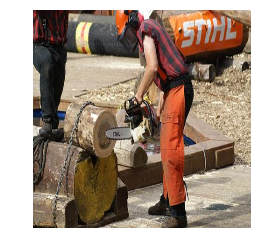

In [ ]:
showTensorImage(firstBatch.xb[0])